# Exploring Kinect Sensor readings of body postures as an indicator of student frustration levels in makerspaces

Mohamed Raouf Seyam

Harvard University

mohamedseyam@gse.harvard.edu

**Overview**: 
In this notebook, we investigate the association between frustraion and body postures as captured by 2 kinect sensors in a makerspace. The aim of this analysis is to examine the correlations between student reported levels of frustration, and clusters of body part (x,y) coordinates captured by the Kinect sensors. This notebook builds on previous analyses in Ramirez et al, 2019

**Participant privacy**
All data used in this notebook was anonymized in a separate notebook



## Reading Data

In [ ]:
# # for Google Colab use only
# from google.colab import drive
# drive.mount('content/')

In [65]:
path = ''

In [171]:
import re
import os
import csv
import math
import seaborn as sns
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy import stats 
from scipy.stats import pearsonr
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline


In [67]:
os.getcwd()

'C:\\Users\\raouf\\Documents\\GitHub\\S435 - Kinect final project - raouf'

In [68]:
os.listdir('../S435 - Kinect final project - raouf')

['.ipynb_checkpoints',
 'all_survey_kinect_data.csv',
 'df_corr.csv',
 'Kinect',
 'Kinect draft.ipynb',
 'Kinect-Final-Project.ipynb',
 'makerspace floorplan.pptx',
 'name.docx',
 'Untitled.ipynb',
 'Untitled1.ipynb']

Reading in student self-reported data and grouping by week

In [69]:
data = pd.read_csv('../S435 - Kinect final project - raouf/all_survey_kinect_data.csv')
data = data.groupby('week', as_index=False).mean()

Reading in  and combining weekly kinect sensor recordings

In [123]:
files = os.listdir('./Kinect/')
print(files)

['.ipynb_checkpoints', 'Untitled.ipynb', 'wk10.csv', 'wk11.csv', 'wk12.csv', 'wk13.csv', 'wk2.csv', 'wk3.csv', 'wk4.csv', 'wk5.csv', 'wk6.csv', 'wk7.csv', 'wk9.csv']


In [124]:
master_df = 0
dfList = []
for filename in os.listdir('./Kinect'):
    if filename.endswith('.csv'):
        path = os.path.join('Kinect', filename)
        x = list(map(int, re.search('\d+', filename).group())) 
        df = pd.read_csv(path)
        df['week'] = ''.join(str(i) for i in x)
        print(len(df))
        if not type(master_df) == pd.core.frame.DataFrame:
            print('start')
            master_df = df
            dfList = [master_df]
        else:
            dfList.append(df)
    
        print('done with ' + filename)

92999
start
done with wk10.csv
96778
done with wk11.csv
66519
done with wk12.csv
87359
done with wk13.csv
83641
done with wk2.csv
36130
done with wk3.csv
47089
done with wk4.csv
44799
done with wk5.csv
133242
done with wk6.csv
70708
done with wk7.csv
21178
done with wk9.csv


In [125]:
master_df = pd.concat(dfList)
master_df.shape

C:\Users\raouf\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(780442, 47)

## Exploratory Data Analysis

<function matplotlib.pyplot.show(*args, **kw)>

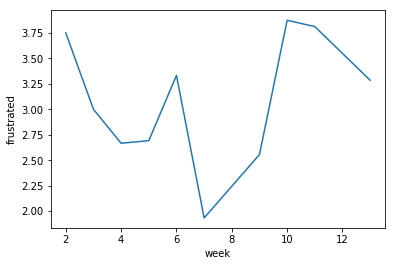

In [88]:
plt.plot(data.week, data.frustrated)
plt.xlabel('week')
plt.ylabel('frustrated')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

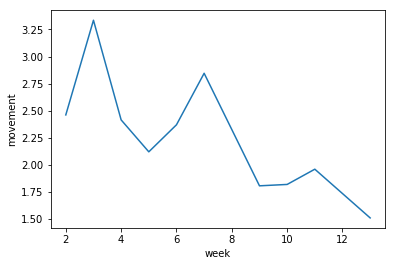

In [87]:
plt.plot(data.week, data.actual_movement/1000)
plt.xlabel('week')
plt.ylabel('movement')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

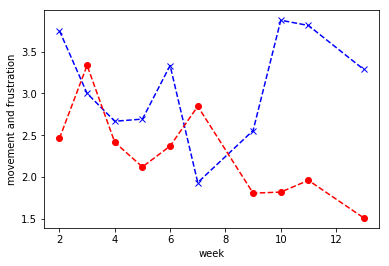

In [84]:
plt.plot(data.week, data.frustrated, 'bx--')
plt.xlabel('week')
plt.plot(data.week, data.actual_movement/1000, 'ro--')
plt.xlabel('week')
plt.ylabel('movement and frustration')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

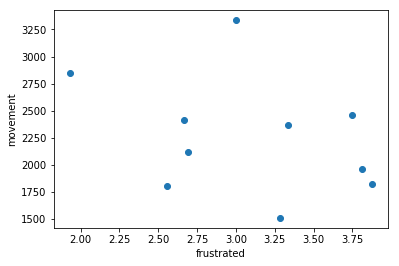

In [90]:
plt.scatter(data.frustrated, data.actual_movement)
plt.xlabel('frustration')
plt.ylabel('movement')
plt.show

In [91]:
np.corrcoef(data.frustrated, data.actual_movement)

array([[ 1.        , -0.35170908],
       [-0.35170908,  1.        ]])

<function matplotlib.pyplot.show(*args, **kw)>

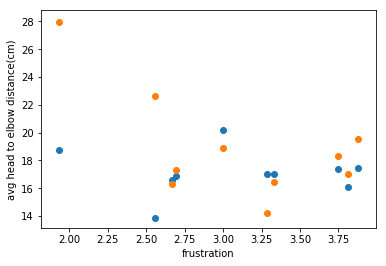

In [103]:
plt.scatter(data.frustrated, data.head_to_elbwR)
plt.scatter(data.frustrated, data.head_to_elbwL)
plt.xlabel('frustration')
plt.ylabel('avg head to elbow distance(cm)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

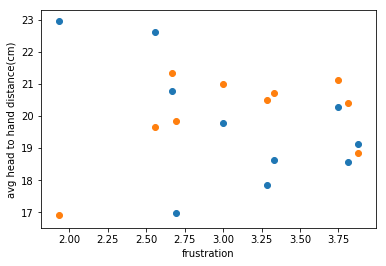

In [108]:
plt.scatter(data.frustrated, data.handL_to_elbowR)
plt.scatter(data.frustrated, data.handR_to_elbowL)
plt.xlabel('frustration')
plt.ylabel('avg head to hand distance(cm)')
plt.show

In [18]:
np.corrcoef(data.frustrated, data.actual_movement)

array([[ 1.        , -0.35170908],
       [-0.35170908,  1.        ]])

In [110]:
np.corrcoef(data.frustrated, data.head_to_handL)

array([[ 1.        , -0.62062003],
       [-0.62062003,  1.        ]])

In [111]:
np.corrcoef(data.frustrated, data.head_to_handR)

array([[ 1.        , -0.26223004],
       [-0.26223004,  1.        ]])

In [126]:
dfcorr = data[['frustrated', 'week', 'hours_assignmt', 'actual_movement',
            'isTalking', 'head_to_handL','head_to_handR',
            'handL_to_elbowR', 'handR_to_elbowL']]
dfcorr.corr()

,frustrated,week,hours_assignmt,actual_movement,isTalking,head_to_handL,head_to_handR,handL_to_elbowR,handR_to_elbowL
frustrated,1.000000,0.202503,0.676626,-0.351709,-0.117985,-0.620620,-0.262230,-0.560660,0.465830
week,0.202503,1.000000,0.149869,-0.759207,0.481550,-0.124961,-0.547696,-0.180487,-0.311862
hours_assignmt,0.676626,0.149869,1.000000,-0.143917,-0.392840,-0.514350,-0.086674,-0.458535,0.318990
actual_movement,-0.351709,-0.759207,-0.143917,1.000000,-0.037280,0.359610,0.891269,0.337535,-0.003682
isTalking,-0.117985,0.481550,-0.392840,-0.037280,1.000000,0.070755,0.007993,0.078847,-0.169534
head_to_handL,-0.620620,-0.124961,-0.514350,0.359610,0.070755,1.000000,0.381602,0.919253,-0.680898
head_to_handR,-0.262230,-0.547696,-0.086674,0.891269,0.007993,0.381602,1.000000,0.219842,-0.323093
handL_to_elbowR,-0.560660,-0.180487,-0.458535,0.337535,0.078847,0.919253,0.219842,1.000000,-0.423849
handR_to_elbowL,0.465830,-0.311862,0.318990,-0.003682,-0.169534,-0.680898,-0.323093,-0.423849,1.000000


C:\Users\raouf\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


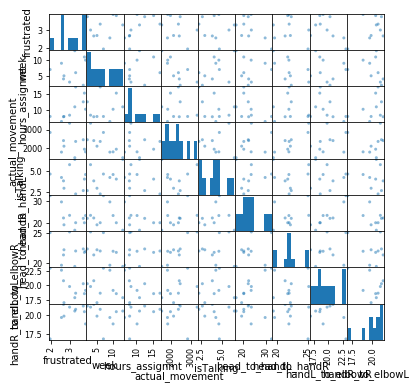

In [130]:
pd.scatter_matrix(dfcorr, figsize=(6, 6))
plt.show()

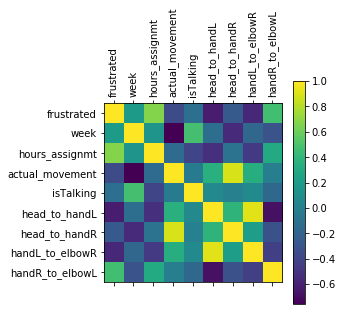

In [116]:
plt.matshow(dfcorr.corr())
plt.xticks(range(len(dfcorr.columns)), dfcorr.columns, rotation=90)
plt.yticks(range(len(dfcorr.columns)), dfcorr.columns, rotation=0)
plt.colorbar()
plt.show()

Survey Data =====
 ['hours_assignmt', 'actual_movement', 'isTalking', 'head_to_handL', 'head_to_handR', 'handL_to_elbowR', 'handR_to_elbowL'] 

Kinect Data =====
 ['frustrated', 'week']


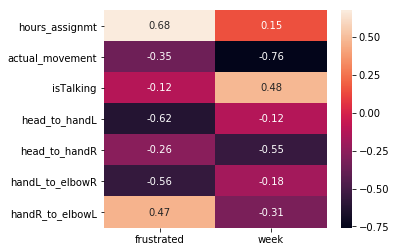

In [139]:
survey = list(dfcorr.columns)[2:]
kinect = list(dfcorr.columns)[0:2]
print('Survey Data =====\n', survey, '\n')
print('Kinect Data =====\n', kinect)

correlations = dfcorr.corr()
fig, ax = plt.subplots(figsize=(5,4)) 
sns.heatmap(correlations.loc[survey][kinect], annot=True)

# Cluster Analysis

## Kmeans

In [38]:
# subset from master df
subset = pd.DataFrame(data=master_df[['HandRight_x', 'HandRight_y',
                                      'ElbowLeft_x', 'ElbowLeft_y',
                                      'HandLeft_x', 'HandLeft_y',
                                     'ElbowRight_x', 'ElbowRight_y']])
subset.shape

In [40]:
# create a list of inertia values for k 1-10
from sklearn.cluster import KMeans

ks = list(range(1, 10))
inertias = []

for k in ks:
    
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k, max_iter=1000)
    
    # Fit model to samples
    kmeans.fit(subset.values)
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)

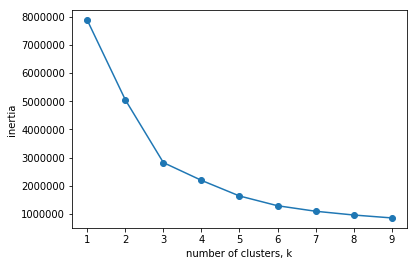

In [41]:
# plot the inertia values using matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Scree plot supports a 3 cluster choice

In [42]:
# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=3)

# Fit model to points
model.fit(subset)

# Determine the cluster labels of new_points: labels
master_df['cluster'] = model.predict(subset)

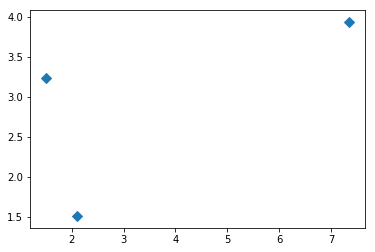

In [43]:
# Assign the cluster centers: centroids
centroids = model.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x, centroids_y, marker='D', s=50)
plt.show()

Creating a new dataframe that includes frustration/week and the number of instances spent in each of the clusters/week

In [45]:
df_count = pd.DataFrame(columns = ['Week','Cluster0','Cluster1','Cluster2'])

df_count['Week'] = [2, 3, 4, 5, 6,  7, 9, 10, 11, 12, 13]

for i in range(2,8):
        df_count_temp = master_df.loc[master_df.week==str(i)]
        for j in range(3):
            df_count_temp1 = df_count_temp.loc[df_count_temp.cluster==j]
            df_count.iat[i-2,j+1]=df_count_temp1.shape[0]

for i in range(9,14):
        df_count_temp = master_df.loc[master_df.week==str(i)]
        for j in range(3):
            df_count_temp1 = df_count_temp.loc[df_count_temp.cluster==j]
            df_count.iat[i-3,j+1]=df_count_temp1.shape[0]


Because week 12 is missing from the student self reported measures csv, it will be skipped in the new dataframe

In [46]:
df_count['frustrated']=""
for i in range(0, 9):
    df_count['frustrated'][i] = dfcorr['frustrated'][i]

df_count['frustrated'][10] = dfcorr['frustrated'][9]

C:\Users\raouf\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\raouf\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [47]:
df_count

,Week,Cluster0,Cluster1,Cluster2,frustrated
0,2,33868,49773,0,3.75
1,3,13154,22976,0,3
2,4,17460,29629,0,2.66667
3,5,11152,33647,0,2.69231
4,6,40133,93109,0,3.33333
5,7,40434,7588,22686,1.93333
6,9,12056,9122,0,2.55556
7,10,29635,63364,0,3.875
8,11,35284,61494,0,3.8125
9,12,24753,41766,0,


In [48]:
# removing week 12 due to missing frustration values
df_count.drop(df_count.index[9])

,Week,Cluster0,Cluster1,Cluster2,frustrated
0,2,33868,49773,0,3.75
1,3,13154,22976,0,3
2,4,17460,29629,0,2.66667
3,5,11152,33647,0,2.69231
4,6,40133,93109,0,3.33333
5,7,40434,7588,22686,1.93333
6,9,12056,9122,0,2.55556
7,10,29635,63364,0,3.875
8,11,35284,61494,0,3.8125
10,13,17245,70114,0,3.28571


Sanity check: added up the total culster values per week and matched to the total number of rows in each week's csv

In [49]:
df_corr = pd.read_csv('../S435 - Kinect final project - raouf/df_corr.csv')

In [50]:
df_corr

,Week,Cluster0,Cluster1,Cluster2,frustrated
0,2,49746,33895,0,3.750
1,3,22973,13157,0,3.000
2,4,29604,17485,0,2.667
3,5,33622,11177,0,2.692
4,6,93081,40161,0,3.333
5,7,7585,40437,22686,1.933
6,9,9109,12069,0,2.556
7,10,63336,29663,0,3.875
8,11,61449,35329,0,3.813
9,13,70093,17266,0,3.286


In [51]:
np.corrcoef(df_corr.Week, df_corr.frustrated)

array([[1.        , 0.20269467],
       [0.20269467, 1.        ]])

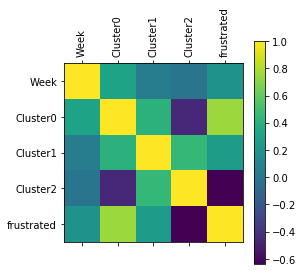

In [52]:
plt.matshow(df_corr.corr())
plt.xticks(range(len(df_corr.columns)), df_corr.columns, rotation=90)
plt.yticks(range(len(df_corr.columns)), df_corr.columns, rotation=0)
plt.colorbar()
plt.show()

Survey Data =====
 ['frustrated'] 

Kinect Data =====
 ['Week', 'Cluster0', 'Cluster1', 'Cluster2']


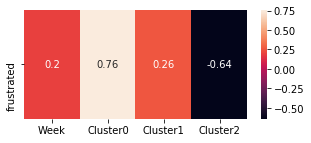

In [59]:
survey = list(df_corr.columns)[4:]
kinect = list(df_corr.columns)[0:4]
print('Survey Data =====\n', survey, '\n')
print('Kinect Data =====\n', kinect)

correlations = df_corr.corr()
fig, ax = plt.subplots(figsize=(5,2)) 
sns.heatmap(correlations.loc[survey][kinect], annot=True)

In [60]:
def calculate_pvalues(df):
    ''' computes the p-value for each correlation'''
    #df = df.dropna()._get_numeric_data()
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            x,y = removeMissingData(df[r],df[c])
            results = stats.pearsonr(x,y)
            pvalues[r][c] = round(results[1], 4)
            #pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

def removeNaN(a):
    return [x for x in a if not math.isnan(x)]

def removeMissingData(a, b):
    x = list(a)
    y = list(b)
    i = len(x) -1
    while(i != -1):  # get rid of missing values
        if x[i] == None or y[i] == None \
        or math.isnan(x[i]) or math.isnan(y[i]):
            del x[i]; del y[i]
        i -= 1
    return (x,y)

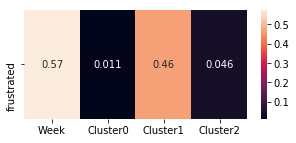

In [62]:
p_values = calculate_pvalues(df_corr).astype(float)
fig, ax = plt.subplots(figsize=(5,2))
sns.heatmap(p_values.loc[survey][kinect], annot=True)

### DBScan 

For computational speed (and because DBScan can be troublesome when n>100,000), only 1 every 100 rows will be seleced for a subsample of 7804

In [180]:
subsample = [i for i in (0, len(subset)) if i % 100 == 0]

In [176]:
subset = subsample.astype("float32", copy = False)

dbscan = DBSCAN(eps=0.5, min_samples=15).fit(subsample)

labels = dbscan.labels_

core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbscan.core_sample_indices_] = True

print("Number of points: %i" % label.size)

ValueError: Expected 2D array, got 1D array instead:
array=[0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
clf = NearestCentroid()
clf.fit(subset.values, label)

print(clf.centroids_.shape)

### NMF

In [164]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

subset[subset.columns] = scaler.fit_transform(subset[subset.columns])

# Import NMF
from sklearn.decomposition import NMF

# Create an NMF instance: model
model = NMF(n_components=6)

# Fit the model to articles
model.fit(subset.values)

# Transform the articles: nmf_features
nmf_features = model.transform(subset.values)

# Print the NMF features
print(nmf_features)

[[0.00940901 0.01799729 0.04915382 0.03820825 0.00036737 0.00094769]
 [0.01847192 0.02992397 0.00202516 0.0209018  0.00608955 0.0035608 ]
 [0.01949091 0.02775157 0.         0.02066241 0.00613836 0.00429351]
 ...
 [0.03798578 0.         0.05819352 0.04069617 0.00357633 0.00194597]
 [0.03886839 0.         0.06028457 0.03881481 0.00325775 0.00075412]
 [0.03895976 0.         0.0586558  0.03804357 0.00332919 0.00115329]]
